In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import *



In [41]:
#Carregar arquivo de tempo x distância
data = pd.read_excel(r'.\xls\tempodist.xls', sheet_name='Plan3')
data

,Tempo (Y),Distância (X)
0,85,45
1,90,46
2,21,16
3,40,32
4,50,39
5,25,18
6,10,7
7,55,41
8,35,28
9,30,24


In [42]:
#Estatística univariadas
data[['Tempo (Y)', 'Distância (X)']].describe()


,Tempo (Y),Distância (X)
count,10.0000,10.00000
mean,44.1000,29.60000
std,26.4426,13.30998
min,10.0000,7.00000
25%,26.2500,19.50000
50%,37.5000,30.00000
75%,53.7500,40.50000
max,90.0000,46.00000


Criando um objecto para calcular a regressão linear

Equação da Reta: $y = A + Bx$

coeficiênte angular (B): $$B = \frac{n\sum x_{i}y_{i} - \sum x_{i} \sum y_{i}}{n \sum x_{i}^{2} - (\sum x_{i}^{2})}$$

coeficiênte linear (A): $$A = \frac{\sum y - B . \sum x}{n}$$

coeficiênte de correlação:

$$ r_{x,y} = \frac{n \sum x_{i} y_{i} - \sum x_{i} \sum y_{i}}{\sqrt{n \sum x_{i}^{2} - (\sum x_{i})^{2}} \sqrt{n \sum y_{i}^{2} - (\sum y_{i})^{2}}}$$


In [45]:
class RegressaoLinear():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.count = x.count()

        self.matriz = pd.DataFrame()
        self.matriz['x'] = self.x
        self.matriz['y'] = self.y
        self.matriz['x²'] = self.x ** 2
        self.matriz['y²'] = self.y ** 2
        self.matriz['xy'] = self.y * self.x
        self.matriz['yhat'] = self.yhat()

    def coeficienteAngular(self):
        return (self.count * self.matriz['xy'].sum() - self.matriz['x'].sum() * self.matriz['y'].sum())/ (self.count * self.matriz['x²'].sum()  - (self.matriz['x'].sum())**2)

    def coeficienteLinear(self):
        return (self.matriz['y'].sum() - self.coeficienteAngular() * self.matriz['x'].sum())/self.count

    def coefCorr(self):
        return (self.count * self.matriz['xy'].sum() - self.matriz['x'].sum() * self.matriz['y'].sum())/(sqrt(self.count * self.matriz['x²'].sum() - (self.matriz['x'].sum())**2) * sqrt(self.count * self.matriz['y²'].sum() - (self.matriz['y'].sum()) ** 2))

    def yhat(self):
        return (self.coeficienteLinear() + self.coeficienteAngular() * self.matriz['x'])

    def erro(self):
        return (self.matriz['y'] - self.matriz['yhat'])

    def squared_erro(self):
        return (self.erro()**2)

    def equacaoReta(self, valorX):
        if valorX > self.matriz['x'].max():
            return f'Não é possível extrapolar o range dos dados coletado .Por Favornseira um valor entre {self.matriz["x"].max()} e {self.matriz["x"].min()}'
        resultado = self.coeficienteLinear() + self.coeficienteAngular() * float(valorX)
        return resultado

rlm = RegressaoLinear(data['Distância (X)'], data['Tempo (Y)'])

#Buscar por resultado
rlm.equacaoReta(42)



67.06146512794781

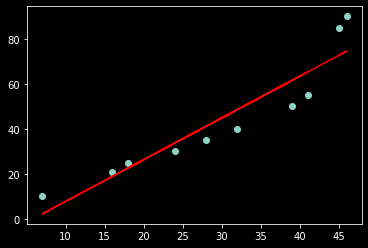

In [44]:
plt.scatter(x = rlm.matriz['x'], y = rlm.matriz['y'])
plt.plot(rlm.matriz['x'], rlm.matriz['yhat'], color = 'red')